In [2]:
"""
Load packages and data 
"""

import numpy as np
from path import Path
import random
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import inf
import scipy.stats as ss
import itertools

SARCOMA_DATA = Path('/data/projects/dncbtd/methylation/sarcoma/data_top5k.npz')
ARRAY_DATA = Path('/data/projects/dncbtd/methylation/breast_ovary_colon_lung/data.npz')
OLIVETTI_DATA = Path('/projects/dncbtd/olivetti_faces/data_first20subjects_3photos.npz')
data_array = np.load(ARRAY_DATA)['Beta_IJ']
data_sarcoma = np.load(SARCOMA_DATA)['Beta_IJ']
data_olivetti = np.load(OLIVETTI_DATA)['Beta_IJ']

(I_a, J_a) = data_array.shape
(I_s,J_s) = data_sarcoma.shape
(I_o,J_o) = data_olivetti.shape

In [3]:
def simulate_TD(I, J, C, K, eta, nu, zeta, epsilon0):
    """
    Function to return a simulated data matrix of beta values [0,1] given the initial hyperparameter values
    """

    theta = ss.gamma.rvs(eta[0], scale=eta[1], size=(I,C))
    phi = ss.gamma.rvs(nu[0], scale=nu[1], size=(K,J))
    pi1 = ss.gamma.rvs(zeta[0], zeta[1], size=(C,K))
    pi2 = ss.gamma.rvs(zeta[0], zeta[1], size=(C,K))
    
    lambda1 = np.matmul(np.matmul(theta, pi1), phi)
    lambda2 = np.matmul(np.matmul(theta, pi2), phi)

    y1 = ss.poisson.rvs(lambda1)
    y2 = ss.poisson.rvs(lambda2)

    beta_ij = ss.beta.rvs(epsilon0[0] + y1, epsilon0[1] + y2)
        
    return beta_ij

In [4]:
def simulate_MF(I, J, K, eta, nu, epsilon0):
    """
    Function to return a simulated data matrix of beta values [0,1] given the initial hyperparameter values
    """

    # eta = (1,1)
    # nu = (1,1)
    # epsilon0 = (1,1)

    theta1 = ss.gamma.rvs(eta[0], scale=eta[1], size=(I,K))
    theta2 = ss.gamma.rvs(eta[0], scale=eta[1], size=(I,K))
    phi = ss.gamma.rvs(nu[0], scale=nu[1], size=(K,J))
    
    lambda1 = np.matmul(theta1, phi)
    lambda2 = np.matmul(theta2, phi)

    y1 = ss.poisson.rvs(lambda1)
    y2 = ss.poisson.rvs(lambda2)

    beta_ij = ss.beta.rvs(epsilon0[0] + y1, epsilon0[1] + y2)
        
    return beta_ij

In [5]:
def kl_divergence(observed_data, simulated_data):
    sums = 0.0
    sums = sum(a * np.log(a/b) + (1-a)*np.log((1-a)/(1-b)) for a,b in zip(observed_data,simulated_data))
    return sums/len(observed_data)

In [6]:
def simulations_hist(I, J, C, K, eta, nu, zeta, epsilon0, observed_data_matrix = data_olivetti):
    """
    Function to determine the MSE of the simulated beta values from the observed beta values and
    plot the two distributions to see their likeliness (histogram)
    """
    
    least_divergence = 1000000000
    beta_ij = []
    least_beta_ij = []
    
    for i in range(2):
        beta_ij = (simulate_TD(I, J, C, K,  eta, nu, zeta, epsilon0)).flatten()
        divergence = mean_squared_error(observed_data_matrix.flatten(), beta_ij)
        if divergence < least_divergence:
            least_divergence = divergence
            least_beta_ij = beta_ij
    
    
    pyplot.hist(observed_data_matrix.flatten(), bins=20, alpha=0.5, label='observed data', density=True)
    pyplot.hist(least_beta_ij, bins=20, alpha=0.5, label='simulated data', density=True)
    pyplot.legend(loc='upper right')
    pyplot.show()
    
    return least_divergence

In [7]:
def simulations_dens_TD(I, J, C, K, eta, nu, zeta, epsilon0, observed_data_matrix = data_olivetti, n_iter = 2, title = None, seed = 617):
    """
    Function to determine the MSE of the simulated beta values from the observed beta values and
    plot the two distributions to see their likeliness (density plot)
    """

    least_divergence = 1000000000
    beta_ij = []
    least_beta_ij = []
    divergences = []
    
    np.random.seed(seed)
    
    for i in range(n_iter):
        beta_ij = (simulate_TD(I, J, C, K,  eta, nu, zeta, epsilon0)).flatten()
        divergence = mean_squared_error(beta_ij, observed_data_matrix.flatten())
        #print(divergence)
        if divergence < least_divergence:
            least_divergence = divergence
            least_beta_ij = beta_ij
        divergences.append(divergence)

    return divergences

In [8]:
def simulations_dens_MF(I, J, K, eta, nu, epsilon0, observed_data_matrix = data_olivetti, n_iter = 2, title = None):
    """
    Function to determine the MSE of the simulated beta values from the observed beta values and
    plot the two distributions to see their likeliness (density plot)
    """

    least_divergence = 1000000000
    beta_ij = []
    least_beta_ij = []
    
    
    for i in range(n_iter):
        beta_ij = (simulate_MF(I, J, K, eta, nu, epsilon0)).flatten()
        divergence = mean_squared_error(beta_ij, observed_data_matrix.flatten())
        if divergence < least_divergence:
            least_divergence = divergence
            least_beta_ij = beta_ij

    plt.figure(figsize=(10,7), dpi= 80)

    sns.distplot(least_beta_ij, color="dodgerblue", label="simulated", hist=False, kde=True)
    sns.distplot(observed_data_matrix.flatten(), color="orange", label="observed", hist=False, kde=True)
    plt.xlabel('Data')
    plt.title(title)

    plt.legend()
    
    
    return least_divergence

/home/gnagulpally/.conda/envs/tucker_env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/gnagulpally/.conda/envs/tucker_env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/gnagulpally/.conda/envs/tucker_env/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

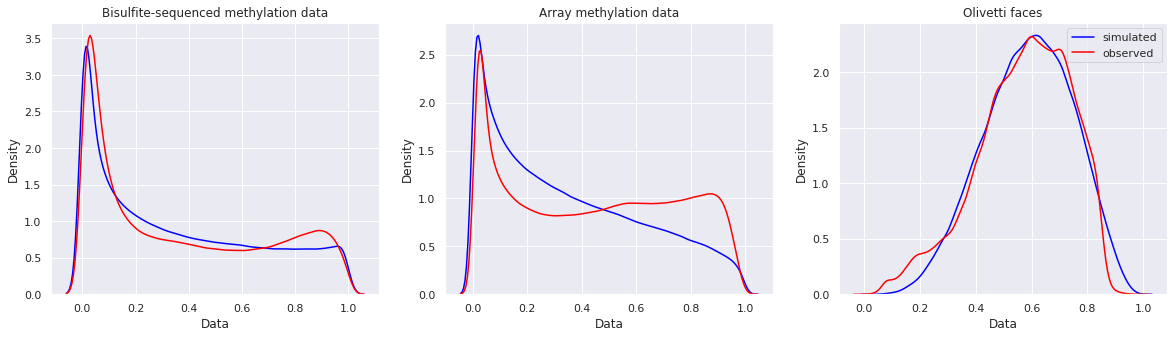

In [9]:
### Make tripartite figure
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].set_title('Bisulfite-sequenced methylation data')
ax[1].set_title('Array methylation data')
ax[2].set_title('Olivetti faces')
ax[0].set_xlabel('Data')
ax[1].set_xlabel('Data')
ax[2].set_xlabel('Data')

eta = (0.1,0.1)
nu = (0.1,0.1)
zeta = (0.1,0.1)

beta_ij = (simulate_TD(I_s, J_s, 10, 20, eta, nu, zeta, epsilon0 = (0.5, 0.9))).flatten()
sns.distplot(beta_ij, color="blue", label="simulated", hist=False, kde=True, ax = ax[0])
sns.distplot(data_sarcoma.flatten(), color="red", label="observed", hist=False, kde=True, ax = ax[0])

beta_ij = (simulate_TD(I_a, J_a, 10, 20, eta, nu, zeta, epsilon0 = (0.7, 1.3))).flatten()
sns.distplot(beta_ij, color="blue", label="simulated", hist=False, kde=True, ax = ax[1])
sns.distplot(data_array.flatten(), color="red", label="observed", hist=False, kde=True, ax = ax[1])

beta_ij = (simulate_TD(I_o, J_o, 20, 30, eta, nu, zeta, epsilon0 = (5, 3.5))).flatten()
sns.distplot(beta_ij, color="blue", label="simulated", hist=False, kde=True, ax = ax[2])
sns.distplot(data_olivetti.flatten(), color="red", label="observed", hist=False, kde=True, ax = ax[2])

ax[2].legend()

plt.savefig('figures/prior_predictive_check.pdf')

In [11]:
### Reproduce Table 1: MSE between real data and data simulated under DNCB-TD model

## Bisulfite sequenced methylation data
eta = (0.1,0.1)
nu = (0.1,0.1)
zeta = (0.1,0.1)
epsilon0 = (0.5, 0.9)
divs = simulations_dens_TD(I_s, J_s, 10, 20, eta, nu, zeta, epsilon0, observed_data_matrix=data_sarcoma, n_iter = 1000, title = "Bisulfite-sequenced methylation data, e0 = {}".format(epsilon0)) 
print("Array data", np.mean(divs), np.sqrt(np.var(divs)))

## Array methylation data
eta = (0.1,0.1)
nu = (0.1,0.1)
zeta = (0.1,0.1)
epsilon0 = (0.7, 1.3)
divs = simulations_dens_TD(I_a, J_a, 10, 20, eta, nu, zeta, epsilon0, observed_data_matrix=data_array, n_iter = 1000, title = "Array methylation data, e0 = {}".format(epsilon0)) 
print("Bisulfite data", np.mean(divs), np.sqrt(np.var(divs)))

## Olivetti faces data
eta = (0.1,0.1)
nu = (0.1,0.1)
zeta = (0.1,0.1)
epsilon0 = (5, 3.5)
divs = simulations_dens_TD(I_o, J_o, 20, 30, eta, nu, zeta, epsilon0, observed_data_matrix=data_olivetti, n_iter = 1000, title = "Olivetti Faces") 
print("Face data", np.mean(divs), np.sqrt(np.var(divs)))

Array data 0.19966995625590006 0.0002267449284898321
Bisulfite data 0.175467799341655 0.00013154753775564284
Face data 0.05382261955907954 0.00012233224452892798
